In [1]:
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
import matplotlib.image
import os
import sys
sys.path.append('/home/bekah/gPhoton2')


In [ ]:
b = 'f'


In [ ]:
# STEP ONE
# stack backplane stacks to get an "all dose" image 

def stack_fits_images(file_list, output_path):
    stacked_image_data = None
    for i, file_path in enumerate(file_list):
        with fits.open(file_path) as hdul:
            image_data = hdul[0].data
            if stacked_image_data is None:
                stacked_image_data = np.zeros_like(image_data, dtype=np.float64)
            stacked_image_data += image_data
    hdu = fits.PrimaryHDU(stacked_image_data)
    hdul = fits.HDUList([hdu])
    hdul.writeto(output_path, overwrite=True)
    print(f"Summed image saved to {output_path}")

# get file list 

directory = f'/media/bekah/BekahA/hotspot/200_stack_{b}uv/correct_stacks'

file_list = [f for f in os.listdir(directory) if f.endswith(('.fits'))]
file_paths = [os.path.join(directory, file_name) for file_name in file_list]

output_path = f'/media/bekah/BekahA/hotspot/200_stack_{b}uv/correct_stacks/all_{b}uv_summed_image.fits'
stack_fits_images(file_paths, output_path)

In [ ]:
# STEP TWO
# dividing stacked image data by the same data with a median filter to produce "filtered" image data
fts2 = fits.open(f'/media/bekah/BekahA/hotspot/200_stack_{b}uv/correct_stacks/all_{b}uv_summed_image.fits')

image = fts2[0].data

filtered_image = median_filter(image, size=10)
filtered = np.ma.divide(image, filtered_image).filled(0)  # Filled with 0 where b is zero
#mask = (image <= 10) | (filtered_image > median*20)
#binary_array = mask.astype(np.uint8)
hdu = fits.PrimaryHDU(filtered)
hdul = fits.HDUList([hdu])
hdul.writeto(f'/media/bekah/BekahA/hotspot/200_stack_{b}uv/correct_stacks/filtered_10_{b}.fits', overwrite=True)
print(f"image saved")


In [ ]:
# STEP THREE
# masking the normalized images created above in "filtered"

fts2 = fits.open(f'/media/bekah/BekahA/hotspot/200_stack_{b}uv/correct_stacks/filtered_10_{b}.fits')
image = fts2[0].data
mask = (image <= .75) | (image > 1.75)
binary_array = mask.astype(np.uint8)
hdu = fits.PrimaryHDU(binary_array)
hdul = fits.HDUList([hdu])
hdul.writeto(f'/media/bekah/BekahA/hotspot/200_stack_{b}uv/correct_stacks/filtered_10_mask_n.fits', overwrite=True)
print(f"image saved")

In [ ]:
# STEP FOUR 
# add buffer to mask image 
from scipy.ndimage import binary_dilation


with fits.open(f'/media/bekah/BekahA/hotspot/200_stack_{b}uv/correct_stacks/derivatives/filtered_10_mask_{b}.fits') as hdul:
    binary_mask = hdul[0].data

buffer_size = 8
structuring_element = np.ones((2*buffer_size+1, 2*buffer_size+1))

dilated_mask = binary_dilation(binary_mask, structure=structuring_element)
hdu = fits.PrimaryHDU(1-dilated_mask.astype(np.uint8))  
hdul_new = fits.HDUList([hdu])
hdul_new.writeto(f'/media/bekah/BekahA/hotspot/200_stack_{b}uv/correct_stacks/derivatives/dilated_mask_filtered10_{b}.fits', overwrite=True)


In [ ]:
# crop downscaled image from the center and save

def crop_center(data, cropx, cropy):
    y, x = data.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return data[starty:starty + cropy, startx:startx + cropx]

def crop_fits(old_file, new_file):
    
    hdul = fits.open(old_file)
    data = hdul[0].data

    cropx, cropy = 100, 100 # how much to crop in either direction

    cropped_data = crop_center(data, cropx, cropy)


    hdul[0].data = cropped_data

    hdul.writeto(new_file, overwrite=True)

    hdul.close()
    
    return cropped_data

In [ ]:
# downscale image 
from scipy.ndimage import zoom
def downscale_fits_image(input_path, output_path, scale_factor=1/5.25):
    with fits.open(input_path) as hdul:
        image_data = hdul[0].data
        crop_amount = 300
        cropped_array = image_data[crop_amount:-crop_amount, crop_amount:-crop_amount]
        
        downscaled_image_data = zoom(cropped_array, zoom=scale_factor, order=0)
        
        # flip array
        downscaled_image_data == np.rot90(np.fliplr(downscaled_image_data))

        hdu = fits.PrimaryHDU(downscaled_image_data)
        hdul_new = fits.HDUList([hdu])
        hdul_new.writeto(output_path, overwrite=True)
    return downscaled_image_data
input_path = f'/media/bekah/BekahA/hotspot/200_stack_{b}uv/correct_stacks/derivatives/dilated_mask_filtered10_{b}.fits'
output_path = f'/media/bekah/BekahA/hotspot/200_stack_{b}uv/correct_stacks/derivatives/dilated_mask_filtered10_downsize_{b}.fits'
downscaled_image_data = downscale_fits_image(input_path, output_path)

In [ ]:
# add inverse of circle border around edge for edge reflections etc 

def add_inverse_circle_overlay(array, radius, outside_value=2):
    rows, cols = array.shape
    center_row, center_col = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    distance_from_center = np.sqrt((x - center_col) ** 2 + (y - center_row) ** 2)
    outside_circle_mask = distance_from_center > radius
    array[outside_circle_mask] += outside_value
    return array


array_with_inverse_circle = add_inverse_circle_overlay(downscaled_image_data, 350, 2)

plt.imshow(array_with_inverse_circle, cmap='gray')
plt.title('border mask added')
plt.colorbar()
plt.show()

In [ ]:
# standard deviation image between all images in folder 

b = "f"
splits = 2

folder_path = f'/media/bekah/BekahA/hotspot/200_stack_{b}uv'
fits_files = [f for f in os.listdir(folder_path) if f.endswith(('NF.fits'))]
images = []

files_split = np.array_split(fits_files, splits)

for i in range(splits): 
    print(i)
    if i > 0: 
            del image_stack
            del std_deviation_image
            del images 
            images = []
    for fits_file in list(files_split[i]):
        fits_path = os.path.join(folder_path, fits_file)
        print(fits_path)
        with fits.open(fits_path) as hdul:
            image_data = hdul[0].data        
            images.append(image_data/np.median(image_data))

    # Convert list of images to a 3D numpy array
    image_stack = np.stack(images, axis=-1)

    # Calculate the standard deviation along the last axis (stack axis)
    std_deviation_image = np.std(image_stack, axis=-1)

    # Save the standard deviation image as a new FITS file
    hdu = fits.PrimaryHDU(std_deviation_image)
    hdul = fits.HDUList([hdu])
    hdul.writeto(f'/media/bekah/BekahA/hotspot/200_stack_{b}uv/standard_deviation_image_{i}.fits', overwrite=True)


In [ ]:
b = "n"

folder_path = f'/media/bekah/BekahA/hotspot/200_stack_{b}uv/correct_stacks'
fits_files = [f for f in os.listdir(folder_path) if f.endswith(('.fits'))]
images = []

for fits_file in fits_files:
        fits_path = os.path.join(folder_path, fits_file)
        print(fits_path)
        with fits.open(fits_path) as hdul:
            image_data = hdul[0].data        
            images.append(image_data/np.median(image_data))

            image_stack = np.stack(images, axis=-1)

std_deviation_image = np.std(image_stack, axis=-1)

hdu = fits.PrimaryHDU(std_deviation_image)
hdul = fits.HDUList([hdu])
hdul.writeto(f'/media/bekah/BekahA/hotspot/200_stack_{b}uv/correct_stacks/derivatives/std_image_all_n.fits', overwrite=True)


In [ ]:
mask = fits.open("/media/bekah/BekahA/hotspot/200_stack_fuv/dilated_mask_filtered10.fits")

In [ ]:
plt.imshow(mask[0].data)

In [ ]:
mask[0].data.shape

In [ ]:
4800 x 4800 size 
goes to 600 x 600 rn 

it needs to be 800 x 800 but the current boundaries are too wide 

In [ ]:
crop_amount = 300
cropped_array = mask[0].data[crop_amount:-crop_amount, crop_amount:-crop_amount]
plt.imshow(cropped_array)

In [ ]:
cropped_array.shape

In [ ]:
4200/800

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Load the FITS file
file_path = '/home/bekah/gPhoton2/gPhoton/cal_data/FUV_wiggle_y.fits'
hdul = fits.open(file_path)
data = hdul[0].data

# Check for -0 and 0 in the data
# Note: In floating point, -0 and 0 are distinct but often displayed the same
# We can use the np.signbit function to find -0 specifically

negative_zero_mask = np.signbit(data) & (data == 0)
positive_zero_mask = ~np.signbit(data) & (data == 0)

# Create an image to visualize the differences
# For example, we can assign different colors to -0 and 0
image = np.zeros((data.shape[0], data.shape[1], 3))

# Assign colors: red for -0, green for +0
image[negative_zero_mask] = [0, 0, 24] # Red for -0
image[positive_zero_mask] = [155, 155, 0]  # Green for 0

# Display the image
plt.imshow(image, cmap='cool')
plt.title('Difference between -0 and 0')
plt.show()

# Close the FITS file
hdul.close()

In [ ]:
hdul[0].header

In [ ]:
import os
from astropy.io import fits
import numpy as np
from scipy.ndimage import median_filter

with fits.open('fuv_2000stack_100seceach_2.fits') as hdul:
    data = hdul[0].data
    
    mask = data > 65
    data[mask] = 40
    median_filtered_data = median_filter(data, size=15)
    data[mask] = median_filtered_data[mask]
    
    hdu = fits.PrimaryHDU(data)
    hdul_out = fits.HDUList([hdu])
    
    # Save the modified data to the output FITS file
    hdul_out.writeto('median_masked_fuvflat.fits', overwrite=True)

In [ ]:
with fits.open('fuv_2500stack_filtered1.fits') as hdul:
    data = hdul[0].data

    mask = data > 0
    median = np.median(data[mask])
    data = hdul[0].data / median
    
    hdu = fits.PrimaryHDU(data)
    hdul_out = fits.HDUList([hdu])
    
    hdul_out.writeto('flat_fuv_normalized_1.fits', overwrite=True)

In [2]:
hdulist = fits.open("/home/bekah/glcat/masks/drawn/fuv_combined_mask_ds_1.fits")

data = hdulist[0].data

# have to transpose NUV so it matches the OG mask orientation
fdata = np.transpose(data) # flip left-right and flip up-down


In [6]:
combo = fdata+(og*6)
hdu = fits.PrimaryHDU(combo.astype(np.uint8))
hdul_out = fits.HDUList([hdu])
hdul_out.writeto('/home/bekah/glcat/masks/drawn/fuv_combo_mask.fits', overwrite=True)

In [3]:
hdulist = fits.open("/media/bekah/BekahA/hotspot/200_stack_fuv/correct_stacks/derivatives/FUV_mask.fits")

og = hdulist[0].data


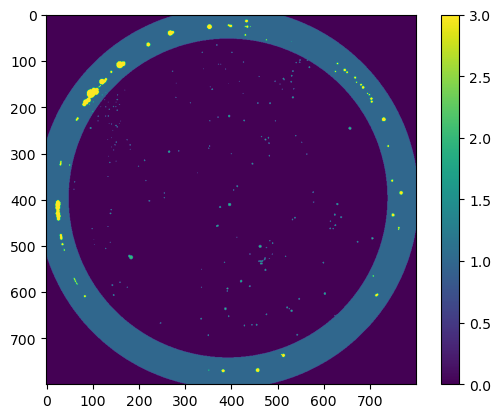

In [4]:
plt.imshow(fdata)
plt.colorbar()

In [ ]:
np.shape(data)

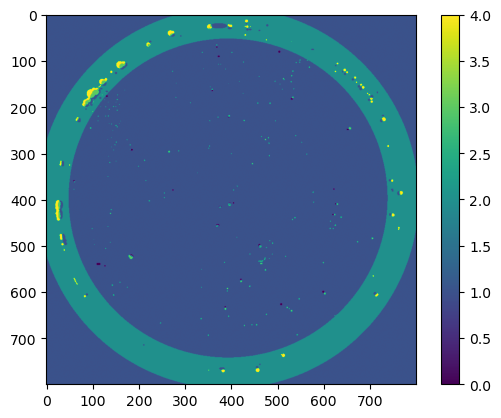

In [6]:
plt.imshow(fdata+og,interpolation=None)
plt.colorbar()

In [ ]:
0-0*2 = 0 # both hotspots 
1-0*2 = 1 # old isn't a hotspot but new is 
0-1*2 = -2 # new isn't a hotspot but old is 

In [ ]:
df = pd.read_csv('every3_fuv.csv')

eclipse_numbers = df['eclipse'].tolist()

step = len(eclipse_numbers) / 1000

sampled_indices = np.arange(0, len(eclipse_numbers), step).astype(int)
sampled_eclipse_numbers = [eclipse_numbers[i] for i in sampled_indices[:1000]]

sampled_df = pd.DataFrame(sampled_eclipse_numbers, columns=['eclipse'])

sampled_df.to_csv('fuv_1000e.csv', index=False)

In [ ]:
from gPhoton.coadd import zero_flag_and_edge
import fitsio

hdulist = fitsio.FITS("/home/bekah/Downloads/e05697-fd-b00-ffull-image-r.fits")

cnt, flag, edge = [hdu.read() for hdu in hdulist[1:4]]

masked_cnt = zero_flag_and_edge(cnt, flag, edge)

In [ ]:
plt.imshow(flag, interpolation=None)

In [4]:
mask = fits.open('/home/bekah/glcat/masks/drawn/fuv_combo_mask_final_b.fits')
inverted_mask = np.abs(mask[0].data - 1)
hdu = fits.PrimaryHDU(inverted_mask)
hdul_out = fits.HDUList([hdu])
hdul_out.writeto('/home/bekah/glcat/masks/drawn/inverted_final_mask_fuv.fits', overwrite=True)